In [1]:
from langchain_groq import ChatGroq
from langgraph.types import interrupt, Command
from langgraph.graph import START, END, StateGraph
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.7)

In [3]:
class state_class(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
def chat_bot(state=state_class):
    "this chatbot will be used for question/answering"

    decision = interrupt(
        {
            "type": "approval",
            "reason": "model is about to answer a user question",
            "question": state['messages'][-1].content,
            "instruction": "approve this question yes/no"
	  }
    )

    if decision['approved'] == 'no':
        return {'messages': [AIMessage(content="NOT APPROVED")]}
    
    else:
        response = llm.invoke(state['messages'])
        return {'messages': [response]}

In [5]:
checkpointer = MemorySaver()
config={'configurable': {'thread_id': 123}}

graph = StateGraph(state_class)

graph.add_node('chat_bot', chat_bot)

graph.add_edge(START, 'chat_bot')
graph.add_edge('chat_bot', END)

chatbot = graph.compile(checkpointer=checkpointer)

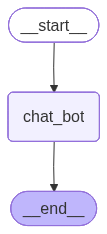

In [6]:
chatbot

In [7]:
user_input = {
    'messages': [
        HumanMessage(
            content='hi how are you?'
	  )
    ]
}

response_with_interrupt = chatbot.invoke(user_input, config=config)
response_with_interrupt

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='ff9c033a-df76-4e7a-805d-39ea62ea901b')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'model is about to answer a user question', 'question': 'hi how are you?', 'instruction': 'approve this question yes/no'}, id='4cb430191efd9f8992ed4b8c93542521')]}

In [8]:
mess = response_with_interrupt['__interrupt__'][0].value
mess

{'type': 'approval',
 'reason': 'model is about to answer a user question',
 'question': 'hi how are you?',
 'instruction': 'approve this question yes/no'}

In [9]:
last_input_for_approval = input(f'BACKEND MESSAGE : {mess}\n\nYES for approval, NO for rejection')
last_input_for_approval

'yes'

In [10]:
final_response = chatbot.invoke(
    Command(resume={'approved': last_input_for_approval}),
    config=config
)
final_response

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='ff9c033a-df76-4e7a-805d-39ea62ea901b'),
  AIMessage(content="Hello. I'm doing well, thanks for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or topics you'd like to discuss. How about you? How's your day going?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 40, 'total_tokens': 102, 'completion_time': 0.120827484, 'completion_tokens_details': None, 'prompt_time': 0.001721595, 'prompt_tokens_details': None, 'queue_time': 0.008327375, 'total_time': 0.122549079}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7fc4-ac81-7aa3-afb0-6acc934e7459-0', usage_metadata={'input_tokens': 4

In [13]:
ai_response = final_response['messages'][-1].content
print(ai_response)

Hello. I'm doing well, thanks for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or topics you'd like to discuss. How about you? How's your day going?
